In [1]:
# Common stuff to import
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(font_scale=1.5)
import pandas as pd

In [2]:
# Special stuff to import
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE

In [3]:
cwd = os.getcwd()
path2data = os.path.join(cwd,'data')

In [4]:
standard = 0
strong = 0
easy_map = [
            {'AP12AmplitudeDropTest':standard},
            {'AP1SSAmplitudeChangeTest':standard},
            {'AP1AmplitudeTest':standard},
            {'AP1WidthHalfHeightTest':standard},
            {'AP1WidthPeakToTroughTest':standard},
            {'AP1RateOfChangePeakToTroughTest':standard},
            {'AP1AHPDepthTest':standard},
            {'AP2AmplitudeTest':standard},
            {'AP2WidthHalfHeightTest':standard},
            {'AP2WidthPeakToTroughTest':standard},
            {'AP2RateOfChangePeakToTroughTest':standard},
            {'AP2AHPDepthTest':standard},
            {'AP12AmplitudeChangePercentTest':standard},
            {'AP12HalfWidthChangePercentTest':standard},
            {'AP12RateOfChangePeakToTroughPercentChangeTest':standard},
            {'AP12AHPDepthPercentChangeTest':standard},
            {'InputResistanceTest':str('ir_currents')},
            {'AP1DelayMeanTest':standard},
            {'AP1DelaySDTest':standard},
            {'AP2DelayMeanTest':standard},
            {'AP2DelaySDTest':standard},
            {'Burst1ISIMeanTest':standard},
            {'Burst1ISISDTest':standard},
            {'InitialAccommodationMeanTest':standard},
            {'SSAccommodationMeanTest':standard},
            {'AccommodationRateToSSTest':standard},
            {'AccommodationAtSSMeanTest':standard},
            {'AccommodationRateMeanAtSSTest':standard},
            {'ISICVTest':standard},
            {'ISIMedianTest':standard},
            {'ISIBurstMeanChangeTest':standard},
            {'SpikeRateStrongStimTest':strong},
            {'AP1DelayMeanStrongStimTest':strong},
            {'AP1DelaySDStrongStimTest':strong},
            {'AP2DelayMeanStrongStimTest':strong},
            {'AP2DelaySDStrongStimTest':strong},
            {'Burst1ISIMeanStrongStimTest':strong},
            {'Burst1ISISDStrongStimTest':strong},
        ]

dm_labels = [list(keys.keys())[0] for keys in easy_map ]


In [5]:
# Open the 1.5x rheobase file
filename = os.path.join(cwd,'onefive_df.pkl')
with open(filename, 'rb') as f:
    df = pickle.load(f)

In [6]:
'''
for col in df.columns:
    for dm in dm_labels:
        if dm in col:
            #print(dm)
            del df[col]
            #print('deleted')
            
'''

"\nfor col in df.columns:\n    for dm in dm_labels:\n        if dm in col:\n            #print(dm)\n            del df[col]\n            #print('deleted')\n            \n"

In [7]:
df.iloc[0][192:195]
del df['InputResistanceTest_1.5x']
del df['InputResistanceTest_3.0x']
del df['ohmic_input_resistance_1.5x']
del df['ohmic_input_resistance_3.0x']

In [8]:
# A function to convert all cells containing array (or other things) into floats.  
def f(x):
    try:
        return np.mean(x)
    except:
        try:
            return np.mean(x['pred'])
        except:
            print(x)
            raise e

# Apply this function to each dataframe in order to convert all cells into floats.
# Also call fillna() first to impute missing values with 0's.  
df = df.fillna(0).applymap(f)
#df_30x = df_30x.fillna(0).applymap(f)

In [9]:
# Join the dataframes horizonstally, so that all features coming from df_15x get a '_1.5x' suffix
# and all the ones from df_30x get a '_3.0x' suffix
#df = df_15x.join(df_30x, lsuffix='_1.5x', rsuffix='_3.0x')

In [10]:
print("There are %d models+data and %d features" % df.shape)

There are 7285 models+data and 462 features


In [11]:
# Impute remaining missing values with 0.
df = df.fillna(0)

In [12]:
# Turn all features into Normal(0,1) variables
# Important since features all have different scales
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df[:] = ss.fit_transform(df.values)
df.groupby(df.index).first()
df = pd.DataFrame.drop_duplicates(df)
print(len(df))

1661


In [13]:
# Check to see what is there.  Might also check to see if there is data there.
#df_30x#.head()

# make model dataframe
model_idx = [idx for idx in df.index.values if type(idx)==str]
model_no_trans_df = df[df.index.isin(model_idx)]
model_no_trans_df.index.name = 'Cell_ID'
model_df = model_no_trans_df.copy()
model_df.index.name = 'Cell_ID'

# make experiment dataframe
experiment_idx = [idx for idx in df.index.values if type(idx)==int]
experiment_no_trans_df = df[df.index.isin(experiment_idx)]
experiment_df = experiment_no_trans_df.copy()
print(len(experiment_df))

696


In [14]:
#print(len(experiment_df))
experiment_df = pd.DataFrame.drop_duplicates(experiment_df)
#experiment_df.index
experiment_df.groupby(experiment_df.index).first()
len(experiment_df)

696

In [15]:
print(len(model_df))
model_df = pd.DataFrame.drop_duplicates(model_df)
model_df.index
model_df.groupby(model_df.index).first()
len(model_df)

965


965

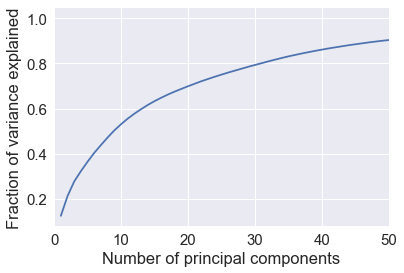

In [16]:
# Do PCA and look at variance explained
pca = PCA()
pca.fit(df.values)
n_features = df.shape[1]
plt.plot(range(1,n_features+1),pca.explained_variance_ratio_.cumsum())
plt.xlim(0,50);
plt.xlabel('Number of principal components')
plt.ylabel('Fraction of variance explained');

In [19]:
# THe transformed values, ordered from highest to lowest variance dimensions
transformed = pca.transform(df.values)


#model_idx = [idx for idx in enumerate(df.index.values) if type(idx)==str]
'''
#label_model_no_trans_df
model_no_trans_df.index.name = 'Cell_ID'
model_df = model_no_trans_df.copy()
model_df.index.name = 'Cell_ID'
'''
# make experiment dataframe
experiment_idx = [idx for idx in df.index.values if type(idx)==int]
model_no_trans_df = df[~df.index.isin(experiment_idx)]
experiment_idx_labels = [(i,idx) for i,idx in enumerate(df.index.values) if type(idx)==int]

#model_df
#df.labels
model_no_trans_df
experiment_idx_labels = [i[0] for i in experiment_idx_labels]
experiment_idx_labels
model_no_trans_df
model_index_labels = ~df.index.isin(experiment_idx)

model_index_labels

array([False, False, False, ...,  True,  True,  True])

<Figure size 432x288 with 0 Axes>

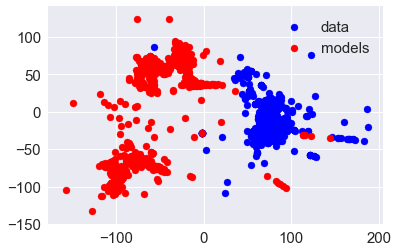

In [20]:
# Do an isomap embedding in 2 dimensions
isomap = Isomap(n_components=2)
isomap.fit(df.values)
iso = isomap.embedding_.T
# Plot that isomap embedding. Each is a model (or a cell, for data)
#plt.scatter(iso);
plt.clf()
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(iso[0,experiment_idx_labels],iso[1,experiment_idx_labels],c='blue',cmap='rainbow',label='data')
plt.scatter(iso[0,model_index_labels],iso[1,model_index_labels],c='red',cmap='rainbow',label='models')
legend = ax.legend()#handles, labels, loc="upper right", title="Sizes")
# I don't love the isomap fit

<Figure size 432x288 with 0 Axes>

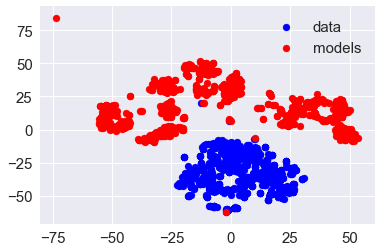

In [23]:
# Do a TSNE embedding in two dimensions
tsne = TSNE(n_components=2, perplexity=30)
tsne.fit(df.values)
x = tsne.embedding_.T
#np.shape(x)
#print(experiment_idx)
# Plot that TSNE embedding. Each is a model (or a cell, for data)
plt.clf()
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(x[0,experiment_idx_labels],x[1,experiment_idx_labels],c='blue',cmap='rainbow',label='data')
plt.scatter(x[0,model_index_labels],x[1,model_index_labels],c='red',cmap='rainbow',label='models')
legend = ax.legend()#handles, labels, loc="upper right", title="Sizes")


In [24]:
#df_data = pd.read_csv(...)
#df_models = pd.read_csv(...)
from sklearn.ensemble import RandomForestClassifier

df_models = df[~df.index.isin(experiment_idx)]
df_data = df[df.index.isin(experiment_idx)]
# Assume they have the same columns

df_combined = pd.concat((df_data, df_models))
#target = np.array([0]*df_models.shape[0] + [1]*df_data.shape[1])
target = np.array(df.index.isin(experiment_idx))

print(np.shape(df_combined))
print(np.shape(target))

rfc = RandomForestClassifier()
rfc.fit(df_combined.values, target)

importances = pd.Series(index = df_combined.columns, data=rfc.feature_importances_)
importances.sort_values(ascending=False)
#rfc.feature_importances_

(1661, 462)
(1661,)


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


sag_amplitude_3.0x                       0.196144
steady_state_voltage_stimend_3.0x        0.099759
voltage_deflection_3.0x                  0.098783
sag_ratio1_3.0x                          0.095874
time_3.0x                                0.094679
depolarized_base_1.5x                    0.086964
AP1RateOfChangePeakToTroughTest_3.0x     0.083573
ISICVTest_1.5x                           0.063689
AP12AmplitudeDropTest_3.0x               0.052843
AP2RateOfChangePeakToTroughTest_3.0x     0.030272
AP1AmplitudeTest_3.0x                    0.029212
ohmic_input_resistance_vb_ssse_1.5x      0.016549
AP2_begin_voltage_3.0x                   0.010280
maximum_voltage_from_voltagebase_3.0x    0.006300
upstroke_index_3.0x                      0.005902
latency_3.0x                             0.003880
fast_trough_t_3.0x                       0.002795
is_not_stuck_1.5x                        0.002501
downstroke_3.0x                          0.002176
AP1DelayMeanTest_3.0x                    0.001734


In [ ]:
#np.shape(x)
#x[0,:]
#X[1,:]

In [ ]:
# PLay around with the value of perplexity. Recommended values are between 5 and 50.  
#See if any of the clusters that pop out mean anything (do they match existing cell type clusters?  
# Do they match known firnig patterns?  
# Where does the data fit in when it is also plotted in this space?)

perplexities = [25,30,35,40]

fig, ax = plt.subplots(2,2,figsize=(8,12),dpi=300)
ax = ax.ravel()

for i, perp in enumerate(perplexities):

    # init = 'pca' or 'random'
    tsne = TSNE(n_components=2,
                init='random',      
                random_state=0,
                perplexity=perp,         # default = 30, should be less than the number of samples
                n_iter=1000)             # default = 1000


    %time tsne.fit(df.values) # can't use transpose


    ax[i].scatter(*tsne.embedding_.T);

    if i in [2,3]:
        ax[i].set_xlabel('TSNE-1')

    if i in [0,2]:
        ax[i].set_ylabel('TSNE-2')
    ax[i].set_title('Perplexity = %s' %perp)

### Repeat above with just experimental data

In [ ]:
# make model dataframe
model_idx = [idx for idx in df.index.values if type(idx)==str]
model_no_trans_df = df[df.index.isin(model_idx)]
model_no_trans_df.index.name = 'Cell_ID'
model_df = model_no_trans_df.copy()
model_df.index.name = 'Cell_ID'

# make experiment dataframe
experiment_idx = [idx for idx in df.index.values if type(idx)==int]
experiment_no_trans_df = df[df.index.isin(experiment_idx)]
experiment_df = experiment_no_trans_df.copy()
experiment_df

In [ ]:
model_df[:] = ss.fit_transform(model_no_trans_df.values);

In [ ]:
model_no_trans_df.head()

In [ ]:
model_df.head()

In [ ]:
# PLay around with the value of perplexity. Recommended values are between 5 and 50.  
#See if any of the clusters that pop out mean anything (do they match existing cell type clusters?  
# Do they match known firnig patterns?  
# Where does the data fit in when it is also plotted in this space?)

perplexities = [25,30,35,40]

df = model_df.copy()

fig, ax = plt.subplots(2,2,figsize=(8,12))
ax = ax.ravel()

for i, perp in enumerate(perplexities):

    # init = 'pca' or 'random'
    tsne = TSNE(n_components=2,
                init='random',      
                random_state=0,
                perplexity=perp,         # default = 30, should be less than the number of samples
                n_iter=1000)             # default = 1000


    %time tsne.fit(df.values) # can't use transpose


    ax[i].scatter(*tsne.embedding_.T);

    if i in [2,3]:
        ax[i].set_xlabel('TSNE-1')

    if i in [0,2]:
        ax[i].set_ylabel('TSNE-2')
    ax[i].set_title('Perplexity = %s' %perp)

In [ ]:
try:
    os.mkdir('data')
except:
    pass
filename = os.path.join(path2data,'new_cortical_ephys.csv')

model_df.to_csv(filename)

filename = os.path.join(path2data,'new_cortical_ephys_no_trans.csv')
model_no_trans_df.to_csv(filename)

filename = os.path.join(path2data,'experiment_ephys_no_trans.csv')
experiment_no_trans_df.to_csv(filename)